```
記得加上na 數量的新feat (也可以加na 數量std)，你們必須統一 CV 的分配

念慈: (your model response should be probability instead of classification label) 
1. Fit a Logistic regression model (Select K by CV) 
2. Fit a CART model 
3. Fit a Random Forest model 

永鴻: 
1. Hyperparameter tuning and feature engineering of LightGBM (AUC should be > 0.81) 
2. LightGBM Cross Validation (you may write it from scratch) 

語謙: 
1. Hyperparameter tuning and feature engineering of XGBoost (AUC should be > 0.81) 
2. XGBoost Cross Validation (you may write it from scratch) 

TO DO: 你們做完後合力做的事情
1. Voting: (XGBoost + LightGBM + CART + Random Forest + Logistic Regression) 
2. KDE plot of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
3. Heatmap of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
4. Fit a CatBoost model 
```
CatBoost : https://ithelp.ithome.com.tw/articles/10275263
```
5. Power Averaging each model (if the correlation of heatmap > threshold (0.95))
```

- L1會趨向於產生少量的特徵，而其他的特徵都是 0


- L2會選擇更多的特徵，這些特徵都會接近於 0 


- Lasso在特徵選擇時候非常有用，而Ridge就只是一種規則化而已


- 在所有特徵中只有少數特徵起重要作用的情況下，選擇Lasso比較合適，因為它能自動選擇特徵


- 而如果所有特徵中，大部分特徵都能起作用，而且起的作用很平均，那麼使用Ridge也許更合適


- 原文：https://blog.csdn.net/sallyxyl1993/article/details/69364181

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### (評分指標)
from sklearn.metrics import roc_auc_score, confusion_matrix

##### 由多種方法組成，在各種迭代器中用於計算快速且代碼高效的解決方案
import itertools                        # 用在 confusion matrix

##### Progress bar (進度條)
from tqdm import tqdm

##### KFOLD
from sklearn.model_selection import KFold


## confusion matrix 圖的配置，把矩陣化成圖

In [2]:
# help('FORMATTING')

In [3]:
##### you may import itertools

def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)   # interpolation : 插值 
    plt.title('Confusion matrix', fontweight='bold', pad=15)     # 字體重量 :'bold'(粗體), pad : 標題放置距離
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))                # classes : list，的長度，的 array，X 的位置
    plt.xticks(tick_marks, classes, rotation=0)         # xticks : 把坐標軸變成自己想要的樣子，類似覆蓋，覆蓋長度要和原來坐標長度一致
    plt.yticks(tick_marks, classes)                     # rotation=0 : 以度為單位的角度
                                                        # rotation='vertical' : 跟座標垂直
    
    thresh = cm.max() / 2.                              # threshold (臨界點)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                                                        # itertools.product : 兩個集合的笛卡爾積，定義為所有有序對 (a, b) 的集合
                                                        # ex : (0,0)、(0,1)、(1,0)、(1,1)
        plt.text(j, i, format(cm[i, j], 'g'),           # 'd' 十進制整數，輸出以 10 為底的數字，細節 : help('FORMATTING')
                 horizontalalignment="center",          # 水平對齊 {'center', 'right', 'left'}
                 color="white" if cm[i, j] > thresh else "black")
                                                        # 數字大於 threshold (臨界點)，給白色，因為 Blues 是淺藍到深

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()                                  # 調整子圖之間和周圍的填充
 

## KFOLD 範例

In [4]:
# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

```python
##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_xgb = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_xgb = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 XGBoost 為例  ####################
        ##### This is nothing to do with KFold (建)
        # params['learning_rate']=0.02                         
        # init_model = XGBClassifier(**params)
        init_model = XGBClassifier(learning_rate = 0.02)                      # 建 model

        ##### You may fit your model here!
        init_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                       early_stopping_rounds=200, verbose=500)                

        ##### Ignore this block
        # params['learning_rate']=0.01
        # model = XGBClassifier(**params)
        model = XGBClassifier(learning_rate = 0.01)

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                  early_stopping_rounds=100, verbose=300, xgb_model=init_model)

        ##### predict validation set and testing set      # 預測 驗證集 & 測試集
        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))[:,-1]            
        y_pred_meta_xgb[val_idx] += np.array([y_pred]).T  # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_xgb += np.array([model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))[:,-1]]).T   
                                                          # 整個測試集的預測，一次就滿了

        ##### calculate your metrics here
        fet_imp += model.feature_importances_             # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                     # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_xgb = y_pred_meta_xgb / float(len(SEEDS))  # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_xgb = y_pred_final_xgb / float(counter)   # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                            # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))
```

In [5]:
# 直接用加 NaN 數量的資料

df_train = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number.csv",index_col='id')
df_test = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number_test.csv",index_col='id')

#路徑字串開頭要寫 r & 檔案名稱.csv                         
# r :為了不讓 \ 被讀成特殊字元 EX: \n
#指定欄位 id 為索引 (取代原本 0.1...957918的位置)

# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782
# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782

df_train.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,5,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,2,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,8,1


In [6]:
df_test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357,1
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125,0
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797,1
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910,0
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796,0


In [6]:
# K-Fold 資料

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

Xtrain = df_train.copy().loc[:,'f1':'Nanumber']
Ytrain = df_train.copy().loc[:,'claim']
Xtest = df_test.copy()


# 1. Fit a Logistic regression model
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://www.3chy2.com.tw/3c%E8%B3%87%E8%A8%8A/%E9%80%9A%E4%BF%97%E5%9C%B0%E8%AA%AA%E9%82%8F%E8%BC%AF%E5%9B%9E%E6%AD%B8%E3%80%90logistic-regression%E3%80%91%E7%AE%97%E6%B3%95%EF%BC%88%E4%BA%8C%EF%BC%89sklearn%E9%82%8F%E8%BC%AF%E5%9B%9E%E6%AD%B8/
- https://www.twblogs.net/a/5cfdeffebd9eee14644e7e47

```
適用於預測二元類別目標變數的發生機率(p)
和線性回歸模型類似，與線性回歸主要不同之處在於
(1) 目標變數是目標事件發生機率P經過log函數轉換成log odds值才進行線性預測
(2) 羅吉斯回歸的各項參數是透過最大概似法(MLE)進行估計的
```

1. **羅吉斯分配中，自變數(X)對依變數(Y)的影響是以指數的方式做變動，因此不需要常態分配的假設**<br><br>
2. **邏輯回歸假設數據服從伯努利分佈，通過極大化似然函數的方法，運用梯度下降來求解參數，來達到將數據二分類的目的**<br><br>
3. **邏輯回歸本身不受量綱影響，但是其使用梯度下降法求解參數受量綱影響大，<br>
    如果不進行特徵歸一化，可能由於變量不同量綱導致參數迭代求解緩慢，影響算法速率**

```
  是否標準化取決於我們的邏輯回歸是不是用L1、L2正則(即算歐式距離)
  
  L1正則時，是簡單將參數的絕對值相加,，因為它們的大小級別不一樣，導致L1只會對級別比較大的參數有作用，那些小的參數將被忽略
  
  不用正則，標準化並不是必須的，損失函數只是僅僅在度量預測與真實的差距

  Note:先拆分出測試集，不要在整個數據集上做標準化，避免將測試集的信息引入到訓練集中
  
```

In [8]:
from sklearn.preprocessing  import StandardScaler     # 標準化 :為了避免偏向某個變數去做訓練
from sklearn.linear_model import LogisticRegression   # 默認 penalty = 'l2'

In [9]:
# ?LogisticRegression  
# C越小，懲罰越重

In [11]:
from sklearn.model_selection import train_test_split  

# LogisticRegressionCV is a logistic regression that uses cross validation.

In [11]:
from sklearn import linear_model, metrics

In [12]:
logidtic_params1 = {
    'Cs': 10,                    # C=1.0 # cs=10
    'class_weight': None,        ###
    'cv': None,                  #
    'dual': False,               ###
    'fit_intercept': True,       ###
    'intercept_scaling': 1.0,    ###
    'l1_ratios': None,           ###
    'max_iter': 100,             ###
    'multi_class': 'auto',       ###
    'n_jobs': None,              ###
    'penalty': 'l2',             ###
    'random_state': 0,           # random_state=None
    'refit': True,               # 'warm_start': True
    'scoring': None,             #
    'solver': 'lbfgs',           ###
    'tol': 0.0001,               ###
    'verbose': 0                 ###
}

In [13]:
Xtrain = Xtrain.fillna(0)                             # 補 0
Xtest = Xtest.fillna(0)                               # Logistic 不能有 NaN

sc=StandardScaler()

sc.fit(Xtrain)                                        # 先拆分出測試集，不要在整個數據集上做標準化，避免將測試集的信息引入到訓練集中

x_train_nor=sc.transform(Xtrain)
x_test_nor=sc.transform(Xtest)

simple_regressor = linear_model.LogisticRegressionCV(**logidtic_params1 )
simple_regressor.fit(X = x_train_nor, y= Ytrain)


LogisticRegressionCV(random_state=0)

In [14]:
predicted_values = simple_regressor.predict(x_train_nor)
predicted_proba = simple_regressor.predict_proba(x_train_nor)[:,1]

print(f'confusion_matrix: {metrics.confusion_matrix(Ytrain, predicted_values)}')
print(f'accuracy_score: {metrics.accuracy_score(Ytrain, predicted_values)}')


print(f'recall_score: {metrics.recall_score(Ytrain, predicted_values)}')
print(f'precision_score: {metrics.precision_score(Ytrain, predicted_values)}')

print(f'f1_score: {metrics.f1_score(Ytrain, predicted_values)}')

print(f'roc_auc_score: {metrics.roc_auc_score(Ytrain, predicted_proba)}')

confusion_matrix: [[373832 106572]
 [144420 333095]]
accuracy_score: 0.7379820214444018
recall_score: 0.6975592389767861
precision_score: 0.757607462011022
f1_score: 0.7263443896631204
roc_auc_score: 0.7992423033170807


In [15]:
predictes_for_test = simple_regressor.predict_proba(x_test_nor)
predictes_for_test

array([[0.60481803, 0.39518197],
       [0.7928882 , 0.2071118 ],
       [0.62471211, 0.37528789],
       ...,
       [0.15522285, 0.84477715],
       [0.77675813, 0.22324187],
       [0.09183715, 0.90816285]])

In [16]:
# 不標準化
# 直接跑不用 kfold 

Xtrain = Xtrain.fillna(0)                             # 補 0
Xtest = Xtest.fillna(0)                               # Logistic 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain,
                                                                    Ytrain,
                                                                    test_size=0.2,
                                                                    random_state=42)

log_model = LogisticRegression(max_iter=10000,verbose=True,penalty='l2')

log_model.fit(data_train,target_train)                # 放訓練!!

# 印出係數
# print(log_model.coef_ ,'\n')

# 印出截距
# print(log_model.intercept_ ,'\n' )

# 機率分類判斷
predictions = log_model.predict_proba(data_test)  # 分別給出各類預測機率

score = roc_auc_score(target_test, predictions[:,-1])                # (957919,)
print(score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


0.507425029718713


In [17]:
predictions = log_model.predict_proba(data_train)
roc_auc_score(target_train, predictions[:,-1])

0.5081023165598509

In [18]:
# 不標準化 # 不用 kfold 

Xtrain = Xtrain.fillna(0)                             # 補 0
Xtest = Xtest.fillna(0)                               # Logistic 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=42)

log_model = LogisticRegression(max_iter=10000,verbose=True,penalty='none')

log_model.fit(data_train,target_train)                # 放訓練!!

# 印出係數
# print(log_model.coef_ ,'\n')

# 印出截距
# print(log_model.intercept_ ,'\n' )

# 機率分類判斷
predictions = log_model.predict_proba(data_test)  # 分別給出各類預測機率

score = roc_auc_score(target_test, predictions[:,-1])                # (957919,)
print(score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


0.507425029718713


In [19]:
predictions = log_model.predict_proba(data_train)
roc_auc_score(target_train, predictions[:,-1])

0.5081023165598509

In [20]:
# 不用 kfold 

Xtrain = Xtrain.fillna(0)                             # 補 0
Xtest = Xtest.fillna(0)                               # Logistic 不能有 NaN

sc=StandardScaler()

sc.fit(Xtrain)                                        # 先拆分出測試集，不要在整個數據集上做標準化，避免將測試集的信息引入到訓練集中

x_train_nor=sc.transform(Xtrain)
x_test_nor=sc.transform(Xtest)

data_train, data_test, target_train, target_test = train_test_split(x_train_nor, Ytrain, test_size=0.2,random_state=42)

log_model = LogisticRegression(max_iter=10000,verbose=True)

log_model.fit(data_train,target_train)                # 放訓練!!

# 印出係數
print(log_model.coef_ ,'\n')

# 印出截距
print(log_model.intercept_ ,'\n' )

# 機率分類判斷
predictions = log_model.predict_proba(data_test)  # 分別給出各類預測機率

score = roc_auc_score(target_test, predictions[:,-1])                # (957919,)
print(score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[-1.38949441e-02 -1.36094068e-02  2.27635932e-02  7.63523731e-03
  -6.79164766e-03  1.55312391e-02  1.35601233e-02  2.99383341e-02
   8.33095517e-03  1.03120184e-02  8.63603138e-03  1.50037288e-03
   7.84105304e-03  1.33127948e-02 -1.48782403e-02  1.02940171e-02
   8.71565907e-04 -1.87348074e-03  3.16818492e-03 -9.17938496e-03
  -2.74806531e-02 -4.16746567e-03  8.48219473e-03 -1.29559501e-02
  -1.14430446e-02  8.07698946e-04  6.48289949e-03  1.28365162e-02
   4.14776288e-03  1.73774866e-02  2.78344803e-02 -2.13744569e-02
  -1.17416905e-03 -4.44408402e-02  2.77623432e-02  1.93062661e-02
  -5.11885478e-03 -1.73571252e-02  1.23767847e-02 -3.11657438e-03
  -9.94939542e-04 -2.81393259e-03  6.14840279e-03 -7.52126023e-03
  -3.10135109e-02 -1.38472459e-02 -2.11493791e-02  1.91737364e-02
   1.82878100e-04  1.30488919e-02 -4.69808387e-03 -2.54086885e-02
   7.74611981e-03 -7.12796516e-03  6.47259026e-03  3.57208094e-03
  -3.30358587e-02  3.35715070e-04  4.22132714e-03 -4.48447753e-03
   1.27006

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


In [21]:
# 標準化 :為了避免偏向某個變數去做訓練

Xtrain = Xtrain.fillna(0)                         # 補 0
Xtest = Xtest.fillna(0)                           # Logistic 不能有 NaN

sc=StandardScaler()
sc.fit(Xtrain)                                    # 先拆分出測試集，不要在整個數據集上做標準化，避免將測試集的信息引入到訓練集中

Xtest  = sc.transform(Xtest)                      ##### 預測時要用 transform 後的測試集去預測 !!!!!

##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_log = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_log = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 Logistic 為例  ####################
        ##### This is nothing to do with KFold (建)
    
        train_x=sc.transform(train_x)
        val_x=sc.transform(val_x)

        log_model = LogisticRegression(max_iter=10000,verbose=2)

        log_model.fit(train_x,train_y)  
        
        ##### predict validation set and testing set      # 預測 驗證集 & 測試集
        y_pred = log_model.predict_proba(val_x)[:,-1]            
        y_pred_meta_log[val_idx] += np.array([y_pred]).T  # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_log += np.array(log_model.predict_proba(Xtest)[:,-1]).T.reshape((Xtest.shape[0], 1))  
                                                          # 整個測試集的預測，一次就滿了，要弄回 2維 (493474, 1)

#########################################################################################################################
        
        ##### calculate your metrics here
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數

y_pred_meta_log = y_pred_meta_log / float(len(SEEDS))  # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_log = y_pred_final_log / float(counter)   # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                            # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



 Seed-24 | Fold-0 | OOF Score: 0.7988754756026479 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished



 Seed-24 | Fold-1 | OOF Score: 0.7979791608674599 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



 Seed-24 | Fold-2 | OOF Score: 0.7995381326682295 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



 Seed-24 | Fold-3 | OOF Score: 0.8001113288358077 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
1it [00:49, 49.21s/it]


 Seed-24 | Fold-4 | OOF Score: 0.7988395058403863 


 Seed: 24 | Aggregate OOF Score: 0.7990687207629061 




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished



 Seed-42 | Fold-0 | OOF Score: 0.7976887705220119 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished



 Seed-42 | Fold-1 | OOF Score: 0.7997294098730139 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished



 Seed-42 | Fold-2 | OOF Score: 0.7984193136313238 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished



 Seed-42 | Fold-3 | OOF Score: 0.7998322419186739 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
2it [01:13, 36.78s/it]


 Seed-42 | Fold-4 | OOF Score: 0.7997507316245783 


 Seed: 42 | Aggregate OOF Score: 0.7990840935139204 


Aggregate OOF Score: 0.7990764071384132


In [22]:
test_log = y_pred_final_log   # 測試集
test_log

array([[0.39518783],
       [0.20711159],
       [0.37528803],
       ...,
       [0.84477103],
       [0.22325396],
       [0.90815888]])

**confusion_matrix**

0.7378786724138471


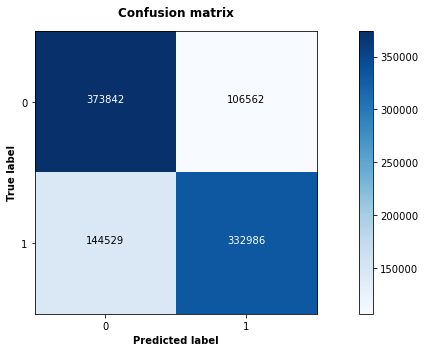

In [23]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_log.ravel()) , labels=[0, 1])  # (957919,)，Series & array


plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


0.7377567518001369


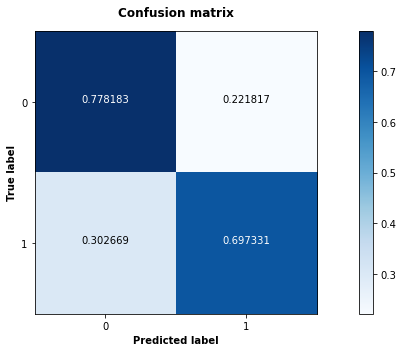

In [24]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_log.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                              # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

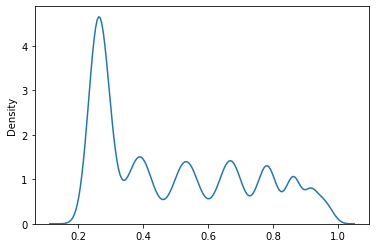

In [25]:
sns.kdeplot( y_pred_final_log.ravel() )

## 看輸出類別 or 連續決定 

**RandomForestClassifier**

**RandomForestRegressor**

**DecisionTreeClassifier**

**DecisionTreeRegressor**

# 2. Fit a CART model 
- https://scikit-learn.org/stable/modules/tree.html

- https://www.796t.com/content/1546975998.html

- https://ithelp.ithome.com.tw/articles/10187191

**屬於無母數回歸方法(non-parametric)：對資料長相的要求不像回歸模型（有母數法，parametric）嚴格，不需要假設資料的線性關係與常態分佈**

- 樹模型的結構不造成影響
```
每個特徵被單獨處理，標準化(數值縮放)，特徵彼此間的分布不會改變
特徵排序順序不變，那麼所屬的分支以及分裂點就不會有不同 == 對數值不關心
所以幾乎不需要數據預處理
```


- 決策樹對變量的量綱差異、離群值的存在以及有偏分佈不太敏感


- 如果某些分類佔優勢，決策樹將會創建一棵有偏差的樹。因此，建議在訓練之前，先抽樣使樣本均衡。


- 有研究表明迴歸模型樣本量選擇中，最好各組樣本含量大於解釋變量數的20倍。


In [7]:
# K-Fold 資料

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

Xtrain = df_train.copy().loc[:,'f1':'Nanumber']
Ytrain = df_train.copy().loc[:,'claim']
Xtest = df_test.copy()


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [9]:
#?DecisionTreeClassifier

In [29]:
# K-Fold 資料     # max_depth = 5

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                                         # 補 0
Xtest = Xtest.fillna(0)                                           # DTs 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)

tree_model = DecisionTreeClassifier(criterion="gini", max_depth=5)
tree_model.fit(data_train, target_train)                                               
# y_new = tree_model.predict(Xtrain)                                         
                                                                             
# 機率分類判斷
tree_predictions = tree_model.predict_proba(data_test) 

tree_score = roc_auc_score(target_test, tree_predictions[:,-1])   # (957919,)
print(tree_score)


0.8000024689772632


[Text(418.5, 498.3, 'X[118] <= 0.5\ngini = 0.5\nsamples = 766335\nvalue = [384621, 381714]'),
 Text(209.25, 407.70000000000005, 'X[33] <= 0.0\ngini = 0.233\nsamples = 287410\nvalue = [248759, 38651]'),
 Text(104.625, 317.1, 'X[20] <= -499.245\ngini = 0.24\nsamples = 153617\nvalue = [132159, 21458]'),
 Text(52.3125, 226.5, 'X[1] <= -0.0\ngini = 0.274\nsamples = 9106\nvalue = [7615, 1491]'),
 Text(26.15625, 135.89999999999998, 'X[91] <= 5717.15\ngini = 0.367\nsamples = 404\nvalue = [306, 98]'),
 Text(13.078125, 45.299999999999955, 'gini = 0.301\nsamples = 293\nvalue = [239, 54]'),
 Text(39.234375, 45.299999999999955, 'gini = 0.479\nsamples = 111\nvalue = [67, 44]'),
 Text(78.46875, 135.89999999999998, 'X[81] <= -1836550016.0\ngini = 0.269\nsamples = 8702\nvalue = [7309, 1393]'),
 Text(65.390625, 45.299999999999955, 'gini = 0.464\nsamples = 60\nvalue = [38, 22]'),
 Text(91.546875, 45.299999999999955, 'gini = 0.267\nsamples = 8642\nvalue = [7271, 1371]'),
 Text(156.9375, 226.5, 'X[2] <= 39

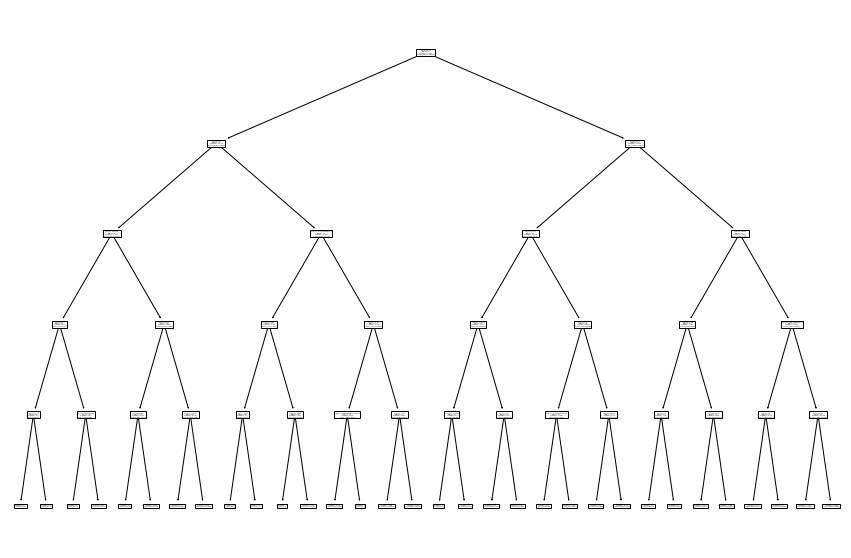

In [30]:
# 畫圖

plt.figure(figsize=(15,10))
plot_tree(tree_model)


In [31]:
# K-Fold 資料     # max_depth=60

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                                         # 補 0
Xtest = Xtest.fillna(0)                                           # DTs 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)

tree_model = DecisionTreeClassifier(criterion="gini", max_depth=60)
tree_model.fit(data_train, target_train)                                               
# y_new = tree_model.predict(Xtrain)                                         
                                                                             
# 機率分類判斷
tree_predictions = tree_model.predict_proba(data_test) 

tree_score = roc_auc_score(target_test, tree_predictions[:,-1])   # (957919,)
print(tree_score)


0.6470442505837063


In [12]:
# K-Fold 資料     # max_depth = 3

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                                         # 補 0
Xtest = Xtest.fillna(0)                                           # DTs 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)

tree_model = DecisionTreeClassifier(criterion="gini", max_depth=3)
tree_model.fit(data_train, target_train)                                               
# y_new = tree_model.predict(Xtrain)                                         
                                                                             
# 機率分類判斷
tree_predictions = tree_model.predict_proba(data_test) 

tree_score = roc_auc_score(target_test, tree_predictions[:,-1])   # (957919,)
print(tree_score)


0.7978588968602722


In [33]:
data_train

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber
id,,,,,,,,,,,,,,,,,,,,,
76287,0.129080,0.19689,383.160,0.049140,0.232380,2.07490,2098.7000,67119.0,8.345700e+15,14279.00,...,-17.1070,1.9376,116.34000,-15.27600,50636.00,1.1394,2.797800e+17,1336.90,0.44329,0
268423,0.172410,0.40379,0.000,0.193150,0.255320,-0.78084,838.1100,26253.0,3.647900e+11,106.66,...,-0.4640,3.5594,-0.91807,11.14900,815.90,0.0000,5.543100e+16,146.61,1.21110,4
759710,0.087129,0.37322,7753.500,0.189680,0.476220,-1.34370,2158.0000,154080.0,2.713600e+13,1286.90,...,-42.8800,1.6331,-1.51820,-4.89060,16297.00,1.2577,2.311000e+17,1936.40,0.38484,0
407862,0.130930,0.42235,840.120,0.359770,0.386020,-0.74311,1069.9000,495910.0,0.000000e+00,8989.20,...,-10.3520,1.1832,0.00000,2.75440,2303.50,1.2713,-3.246500e+15,1154.50,0.50500,3
702064,0.100640,0.33895,36.752,0.121410,0.249640,2.96150,49.0500,368520.0,1.612000e+14,710.89,...,-13.7880,1.4813,0.00000,8.47470,7694.40,1.2687,7.589200e+16,1818.60,0.43702,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478609,0.047503,0.35926,3754.700,0.376450,0.000118,2.82590,975.3700,1007700.0,1.196700e+13,6223.00,...,-4.1333,3.7459,0.76608,5.99530,6813.90,1.1452,2.027700e+17,772.85,1.27660,0
516439,0.091182,0.49819,1091.300,0.151000,0.380930,7.34900,1330.4000,269890.0,1.826500e+14,118.97,...,-19.9780,1.8891,41.44500,11.85200,-512.55,1.1570,2.180400e+17,2203.90,0.39213,0
211136,0.065780,0.16348,18492.000,0.174960,0.409120,1.12150,1131.8000,0.0,1.773700e+15,230.25,...,-2.0213,2.2908,-6.77860,15.15300,772.61,1.2025,9.614400e+16,1001.10,0.46472,2


[Text(558.0, 713.475, 'Nanumber <= 0.5\ngini = 0.5\nsamples = 766335\nvalue = [384621, 381714]'),
 Text(279.0, 509.625, 'f34 <= 0.0\ngini = 0.233\nsamples = 287410\nvalue = [248759, 38651]'),
 Text(139.5, 305.775, 'f21 <= -499.245\ngini = 0.24\nsamples = 153617\nvalue = [132159, 21458]'),
 Text(69.75, 101.92499999999995, 'gini = 0.274\nsamples = 9106\nvalue = [7615, 1491]'),
 Text(209.25, 101.92499999999995, 'gini = 0.238\nsamples = 144511\nvalue = [124544, 19967]'),
 Text(418.5, 305.775, 'f35 <= -31197000368128.0\ngini = 0.224\nsamples = 133793\nvalue = [116600, 17193]'),
 Text(348.75, 101.92499999999995, 'gini = 0.197\nsamples = 13803\nvalue = [12272, 1531]'),
 Text(488.25, 101.92499999999995, 'gini = 0.227\nsamples = 119990\nvalue = [104328, 15662]'),
 Text(837.0, 509.625, 'Nanumber <= 1.5\ngini = 0.406\nsamples = 478925\nvalue = [135862, 343063]'),
 Text(697.5, 305.775, 'f3 <= 203.435\ngini = 0.486\nsamples = 108395\nvalue = [45282, 63113]'),
 Text(627.75, 101.92499999999995, 'gini

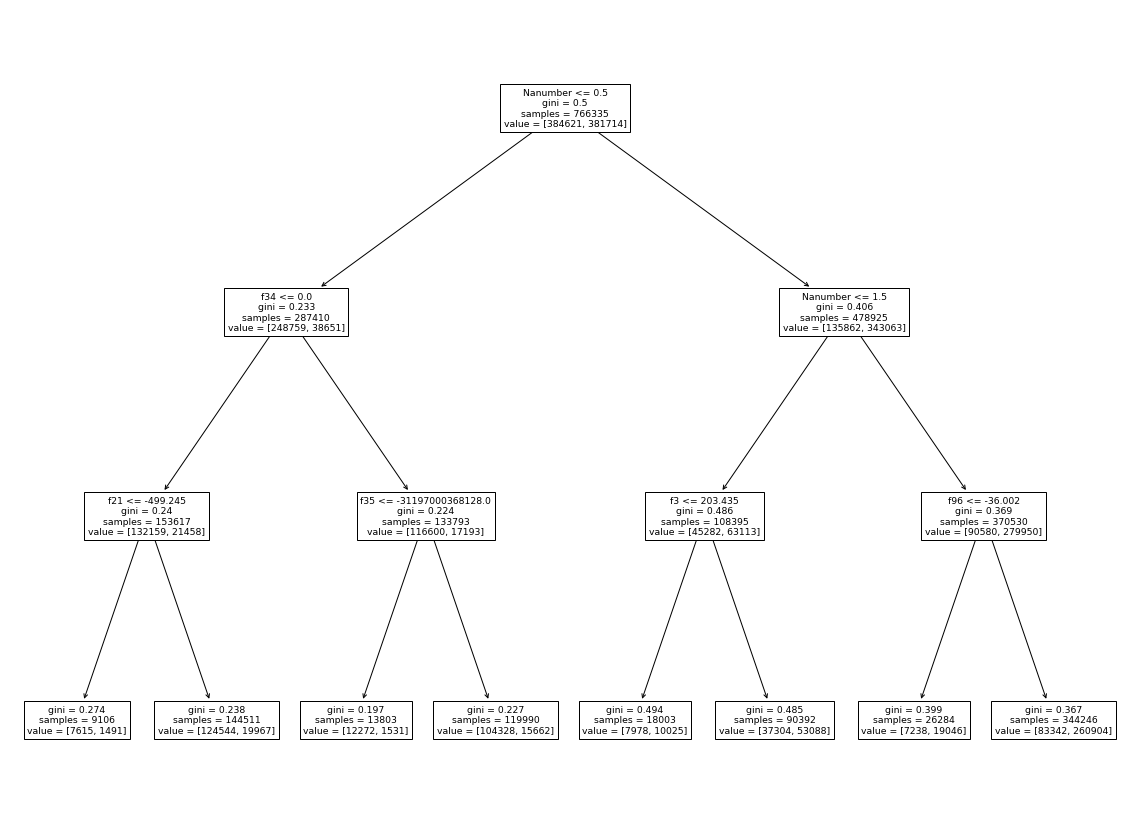

In [18]:
# 畫圖

features = [column for column in Xtrain]
plt.figure(figsize=(20,15))
plot_tree(tree_model,feature_names=features) # feature_names = features，要是字串


In [35]:
# K-Fold 資料     # max_depth=2

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

# 直接跑不用 kfold

Xtrain = Xtrain.fillna(0)                                         # 補 0
Xtest = Xtest.fillna(0)                                           # DTs 不能有 NaN

data_train, data_test, target_train, target_test = train_test_split(Xtrain, Ytrain, test_size=0.2,random_state=24)

tree_model = DecisionTreeClassifier(criterion="gini", max_depth=2)
tree_model.fit(data_train, target_train)                                               
# y_new = tree_model.predict(Xtrain)                                         
                                                                             
# 機率分類判斷
tree_predictions = tree_model.predict_proba(data_test) 

tree_score = roc_auc_score(target_test, tree_predictions[:,-1])   # (957919,)
print(tree_score)


0.7968934329305992


In [36]:
# max_depth = 60


Xtrain = Xtrain.fillna(0)                                       # 補 0
Xtest = Xtest.fillna(0)                                         # DTs 不能有 NaN

##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_tree = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_tree = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 Decision Tree 為例  ##############
        ##### This is nothing to do with KFold (建)

        tree_model = DecisionTreeClassifier(criterion="gini", max_depth=60)
        tree_model.fit(train_x, train_y)
        # y_new = tree_model.predict(Xtrain) 

        ##### predict validation set and testing set       # 預測 驗證集 & 測試集
    
        y_pred = tree_model.predict_proba(val_x)[:,-1]            
        y_pred_meta_tree[val_idx] += np.array([y_pred]).T  # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_tree += np.array(tree_model.predict_proba(Xtest)[:,-1]).T.reshape((Xtest.shape[0], 1))  
                                                           # 整個測試集的預測，一次就滿了，要弄回 2維 (493474, 1)

########################################################################################################################            

        ##### calculate your metrics here
        fet_imp += tree_model.feature_importances_        # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                        # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_tree = y_pred_meta_tree / float(len(SEEDS))   # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_tree = y_pred_final_tree / float(counter)    # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                               # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s]


 Seed-24 | Fold-0 | OOF Score: 0.6463768878472134 


 Seed-24 | Fold-1 | OOF Score: 0.6440064818662827 


 Seed-24 | Fold-2 | OOF Score: 0.6428249523356397 


 Seed-24 | Fold-3 | OOF Score: 0.6441684475902703 



1it [38:09, 2289.03s/it]


 Seed-24 | Fold-4 | OOF Score: 0.6476577517294464 


 Seed: 24 | Aggregate OOF Score: 0.6450069042737705 



 Seed-42 | Fold-0 | OOF Score: 0.6440335228837116 


 Seed-42 | Fold-1 | OOF Score: 0.6439043507843777 


 Seed-42 | Fold-2 | OOF Score: 0.6421792109255211 


 Seed-42 | Fold-3 | OOF Score: 0.6455134408007909 



2it [1:12:34, 2177.49s/it]


 Seed-42 | Fold-4 | OOF Score: 0.6473683788139545 


 Seed: 42 | Aggregate OOF Score: 0.6445997808416711 


Aggregate OOF Score: 0.6448033425577209


In [37]:
dctdepth_60 = y_pred_final_tree   # 測試集
dctdepth_60

array([[0.6 ],
       [0.01],
       [0.6 ],
       ...,
       [0.8 ],
       [0.11],
       [1.  ]])

**confusion_matrix**

0.6296795449302081


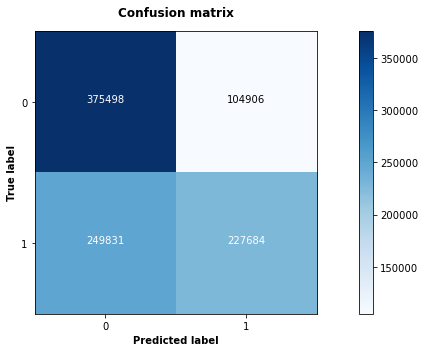

In [38]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_tree.ravel()) , labels=[0, 1])  # (957919,)，Series & array


plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


0.6292198904783762


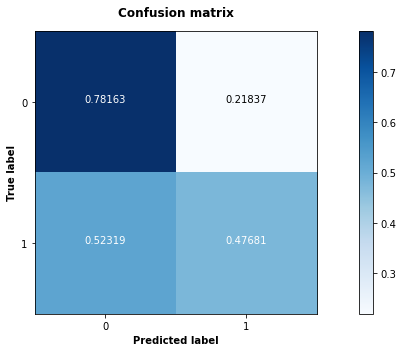

In [39]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_tree.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                               # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

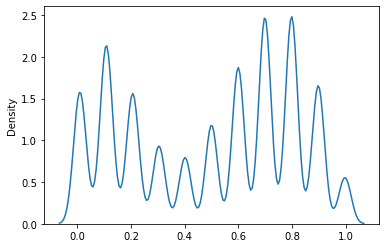

In [40]:
sns.kdeplot( y_pred_final_tree.ravel() )

In [41]:
# max_depth = 5


Xtrain = Xtrain.fillna(0)                                       # 補 0
Xtest = Xtest.fillna(0)                                         # DTs 不能有 NaN

##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_tree = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_tree = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數

    ##### start KFold

    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 

        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完

############################################################################  # 以下以 Decision Tree 為例  ##############
        ##### This is nothing to do with KFold (建)

        tree_model = DecisionTreeClassifier(criterion="gini", max_depth=5)
        tree_model.fit(train_x, train_y)
        # y_new = tree_model.predict(Xtrain) 

        ##### predict validation set and testing set       # 預測 驗證集 & 測試集
    
        y_pred = tree_model.predict_proba(val_x)[:,-1]            
        y_pred_meta_tree[val_idx] += np.array([y_pred]).T  # 第 1/5 份驗證集的預測，5次才會滿

        y_pred_final_tree += np.array(tree_model.predict_proba(Xtest)[:,-1]).T.reshape((Xtest.shape[0], 1))  
                                                           # 整個測試集的預測，一次就滿了，要弄回 2維 (493474, 1)

########################################################################################################################            

        ##### calculate your metrics here
        fet_imp += tree_model.feature_importances_        # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數

        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分

    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                        # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_tree = y_pred_meta_tree / float(len(SEEDS))   # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_tree = y_pred_final_tree / float(counter)    # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                               # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s]


 Seed-24 | Fold-0 | OOF Score: 0.8000024689772632 


 Seed-24 | Fold-1 | OOF Score: 0.7998571171556973 


 Seed-24 | Fold-2 | OOF Score: 0.8004317775749922 


 Seed-24 | Fold-3 | OOF Score: 0.8007965573386104 



1it [05:02, 302.90s/it]


 Seed-24 | Fold-4 | OOF Score: 0.7994068534740038 


 Seed: 24 | Aggregate OOF Score: 0.8000989549041133 



 Seed-42 | Fold-0 | OOF Score: 0.7986493842043213 


 Seed-42 | Fold-1 | OOF Score: 0.800868873022804 


 Seed-42 | Fold-2 | OOF Score: 0.7993011674102101 


 Seed-42 | Fold-3 | OOF Score: 0.8009613011039297 



2it [10:06, 303.13s/it]


 Seed-42 | Fold-4 | OOF Score: 0.8003615492041063 


 Seed: 42 | Aggregate OOF Score: 0.8000284549890744 


Aggregate OOF Score: 0.8000637049465936


In [42]:
max_depth_5 = y_pred_final_tree   # 測試集
max_depth_5

array([[0.58],
       [0.13],
       [0.6 ],
       ...,
       [0.76],
       [0.12],
       [0.75]])

**confusion_matrix**

0.7723116463918139


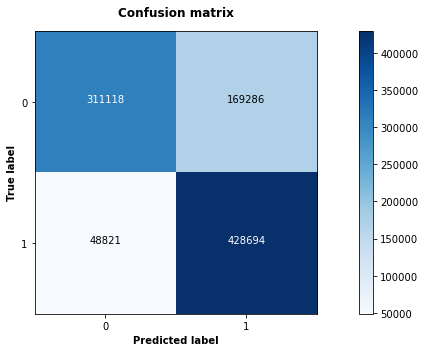

In [43]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_tree.ravel()) , labels=[0, 1])  # (957919,)，Series & array

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


0.7726888508924672


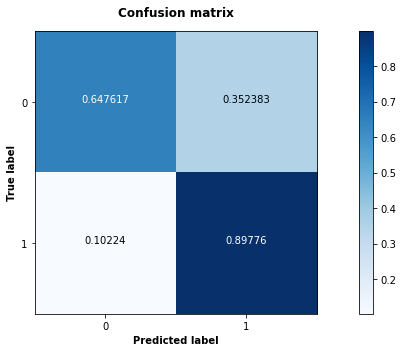

In [44]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_tree.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                               # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

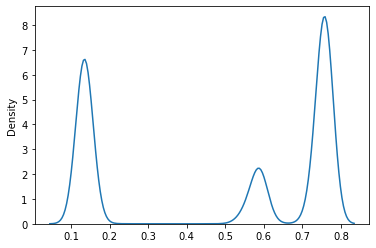

In [45]:
sns.kdeplot( max_depth_5.ravel() )

[Text(150.95892857142857, 199.32, 'X[118] <= 0.5\ngini = 0.5\nsamples = 766336\nvalue = [384319, 382017]'),
 Text(62.775, 163.07999999999998, 'X[34] <= -29039000551424.0\ngini = 0.234\nsamples = 287635\nvalue = [248675, 38960]'),
 Text(29.892857142857142, 126.83999999999999, 'X[52] <= 124.175\ngini = 0.208\nsamples = 29745\nvalue = [26239, 3506]'),
 Text(23.914285714285715, 90.6, 'X[56] <= -0.001\ngini = 0.208\nsamples = 29741\nvalue = [26239, 3502]'),
 Text(11.957142857142857, 54.359999999999985, 'X[109] <= -73.677\ngini = 0.225\nsamples = 11396\nvalue = [9926, 1470]'),
 Text(5.978571428571429, 18.119999999999976, 'gini = 0.36\nsamples = 187\nvalue = [143, 44]'),
 Text(17.935714285714287, 18.119999999999976, 'gini = 0.222\nsamples = 11209\nvalue = [9783, 1426]'),
 Text(35.871428571428574, 54.359999999999985, 'X[0] <= 0.006\ngini = 0.197\nsamples = 18345\nvalue = [16313, 2032]'),
 Text(29.892857142857142, 18.119999999999976, 'gini = 0.265\nsamples = 1083\nvalue = [913, 170]'),
 Text(41

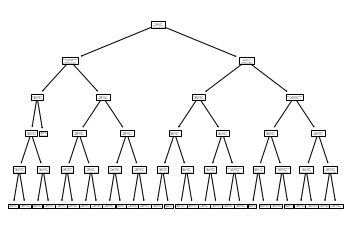

In [46]:
# 畫圖     # max_depth = 5

plot_tree(tree_model)


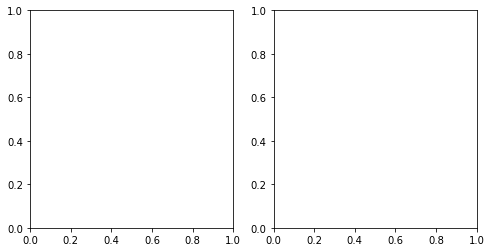

In [47]:
fig = plt.figure(figsize=(8,4))
axs = fig.subplots(1,2)

# plt.figure(1)
# plt.figure(2)

In [48]:
test_log1 = pd.DataFrame(test_log)
max_depth_51 = pd.DataFrame(max_depth_5)


In [49]:
logdct = pd.concat(((Xtest.reset_index().iloc[:,0],test_log1, max_depth_51)), axis = 'columns')  # 需要轉 dataframe
logdct.columns = ['id','Logistic','dctdepth_5']
logdct

,id,Logistic,dctdepth_5
0,957919,0.395188,0.583207
1,957920,0.207112,0.129017
2,957921,0.375288,0.595605
3,957922,0.263373,0.144138
4,957923,0.285499,0.151109
...,...,...,...
493469,1451388,0.581088,0.762203
493470,1451389,0.216424,0.129017
493471,1451390,0.844771,0.757146
493472,1451391,0.223254,0.123806


In [50]:
# logdct.to_csv("C:/Users/user/Desktop/logdct_hat.csv") 